In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_transactions = pd.read_json('transactions.json', lines=True)
df_users = pd.read_csv('users.csv')
df_merchants = pd.read_csv('merchants.csv')

In [3]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')

# Then, join the result with df_merchants on merchant_id
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')


In [5]:
df = df_merged

In [6]:
categorical_cols = [
    'channel', 'currency', 'device', 'payment_method', 'category',
    'country_x', 'country_y', 'sex', 'education', 'primary_source_of_income'
]

binary_cols = [
    'is_international', 'is_first_time_merchant', 'has_fraud_history'
]

numerical_cols = [
    'amount', 'session_length_seconds', 'age', 'risk_score', 'trust_score',
    'number_of_alerts_last_6_months', 'avg_transaction_amount',
    'account_age_months', 'sum_of_monthly_expenses', 'sum_of_monthly_installments'
]

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# Temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['days_since_signup'] = (df['timestamp'] - df['signup_date']).dt.total_seconds() / (3600 * 24)

numerical_cols += ['hour', 'day_of_week', 'days_since_signup']

# Location
df['lat'] = df['location'].apply(lambda x: x['lat'] if isinstance(x, dict) else np.nan)
df['long'] = df['location'].apply(lambda x: x['long'] if isinstance(x, dict) else np.nan)

numerical_cols += ['lat', 'long']

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

for col in binary_cols:
    df[col] = df[col].astype(int)

In [13]:
import numpy as np

user_column = 'user_id'
target_column = 'is_fraud'

sequence_length = 10  # This we can fine tune probably down to like 3
data_sequences = []
labels = []

# Padding value 
padding_value = 0  

# Group by the user
grouped = df.groupby(user_column)

# Loop over each user
for user_id, user_data in grouped:
    # sort by timestap
    user_data = user_data.sort_values(by='timestamp')
    
    # to np arrays
    user_data_values = user_data[numerical_cols].values
    
    # pad with zeros if too few transactions
    if len(user_data) < sequence_length:
        
        pad_length = sequence_length - len(user_data)
        padding = np.full((pad_length, len(numerical_cols)), padding_value)  # Pad with zeros or np.nan
        user_data_values = np.vstack([padding, user_data_values])  # Add padding at the beginning
    
    # Generate sequences 
    for i in range(sequence_length, len(user_data_values)):
        data_sequences.append(user_data_values[i-sequence_length:i])  # Create sequence
        labels.append(user_data[target_column].iloc[i])  # Append corresponding label

# Convert to np arrays
data_sequences = np.array(data_sequences)
labels = np.array(labels)



In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_sequences, labels, test_size=0.2, random_state=42)


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Define RNN Model
model = Sequential()

# Adding RNN Layer(s)
model.add(SimpleRNN(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(SimpleRNN(units=32))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  


C:\Users\antek\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


y_train_class = y_train  

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = dict(zip(np.unique(y_train_class), class_weights))

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict, validation_data=(X_test, y_test))

Epoch 1/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5095 - loss: 0.7122 - val_accuracy: 0.4515 - val_loss: 0.7078
Epoch 2/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.4876 - loss: 0.6947 - val_accuracy: 0.4749 - val_loss: 0.6969
Epoch 3/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.4884 - loss: 0.6969 - val_accuracy: 0.5935 - val_loss: 0.6864
Epoch 4/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5416 - loss: 0.6911 - val_accuracy: 0.3363 - val_loss: 0.7025
Epoch 5/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.4589 - loss: 0.6978 - val_accuracy: 0.5323 - val_loss: 0.6900
Epoch 6/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5170 - loss: 0.6925 - val_accuracy: 0.4830 - val_loss: 0.6939
Epoch 7/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5202 - loss: 0.6933 - val_accuracy: 0.4730 - val_loss: 0.6952
Epoch 8/10
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5186 - loss: 0

1876/1876 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step


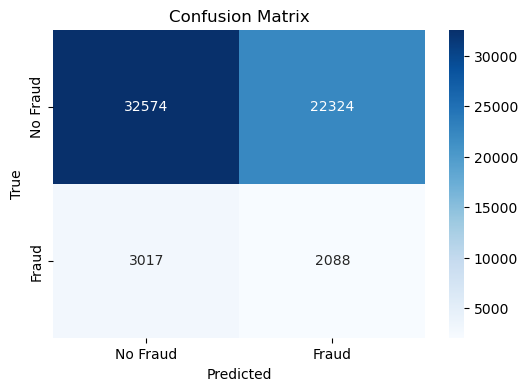

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.59      0.72     54898
           1       0.09      0.41      0.14      5105

    accuracy                           0.58     60003
   macro avg       0.50      0.50      0.43     60003
weighted avg       0.84      0.58      0.67     60003

AUC: 0.5064966962682356


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)  
y_pred_class = (y_pred > 0.5).astype(int)  


cm = confusion_matrix(y_test, y_pred_class)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:\n", classification_report(y_test, y_pred_class))


auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')